In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Software patents
1. Get all software patents
2. Sample within Computers; indicate whether the *tp* or *op* is a software patent

Code mostly taken from https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/Results/Regressions/1-NewSample.ipynb

In [2]:
# 1. Software in abstract
pabs = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas()
print(len(pabs))
pabs = pabs.loc[pabs["abs_stemmed"].str.contains('software|softwar', regex=True)]
print(len(pabs))
sw_pats = pabs["patent"]
print(len(sw_pats))
sw_pats.to_pickle("DataStore/2018-07-P2/sw_pats.pkl")
# del(pabs)

2575725
28249
28249


In [3]:
# Load data
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
print(len(pdf))
pdf = pdf.drop_duplicates("patent")
# Remove actual duplicates
dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl")
pdf = pdf.loc[~(pdf["patent"].isin(dup_pats))]
print(len(pdf))
# Check that I have vector data for them
pabs = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
pdf = pdf.loc[pdf["patent"].isin(pabs)]
print(len(pdf))
del(dup_pats, pabs)

2523739
2220706
2002788


In [ ]:
def get_year_group(x):
    if x in range(1975,1980):
        yg = "1975-80"
    elif x in range(1980,1985):
        yg = "1980-85"
    elif x in range(1985, 1990):
        yg = "1985-90"
    elif x in range(1990,1995):
        yg = "1990-95"
    elif x in range(1995,2000):
        yg = "1995-00"
    elif x in range(2000,2005):
        yg = "2000-05"
    elif x in range(2005,2010):
        yg = "2005-10"
    elif x in range(2010, 2015):
        yg = "2010-15"
    else:
        yg = np.nan
    return yg

pdf["year_group"] = pdf["appyear"].apply(get_year_group)
# Drop missing columns
pdf = pdf.dropna(how="any",subset=["appyear", "naics_name", "primclass", "year_group"])
print(len(pdf))

1521233


In [ ]:
c = "naics_name"
k = "year_group"
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))
print(c)
print(datetime.datetime.now())
sw2 = pdf.loc[pdf["patent"].isin(sw_pats), ["patent", k]].groupby(k)
p2 = pdf.loc[pdf[c].isin(["Computer and Peripheral Equipment"]) & (pdf["appyear"] >= 1985)]
print(len(p2))
pg = p2.groupby(k)
ts = pd.DataFrame()
for n,g in pg:
    s = pd.DataFrame()
    samp = list(zip(g.sample(n=len(g)*10, replace=True)["patent"].tolist(),\
                    g.sample(n=len(g)*10, replace=True)["patent"].tolist()))
    # Sort in order
    samp = [(i,j) if (i<j)==True else (j,i) for (i,j) in samp]
    s["tp"] = [i[0] for i in samp]
    s["op"] = [i[1] for i in samp]
    ts = ts.append(s, ignore_index = True)
print(len(ts))
    
# Check that target and other do not have same assignee
%time asg_match = (set(asgs.get(tp, [])).intersection(asgs.get(op, [])) for tp, op in zip(ts["tp"], ts["op"]))
%time asg_match = [len(i) for i in asg_match]

ts["asg_match"] = asg_match
ts = ts.loc[ts["asg_match"] == 0]
ts = ts.drop("asg_match",1)
print(len(ts))

In [ ]:
print(len(ts.loc[ts["tp"].isin(sw_pats)]))
print(len(ts.loc[ts["op"].isin(sw_pats)]))

In [ ]:
ts.to_pickle("DataStore/2018-07-P2/Software/computer_sw_samp_0721.pkl")

## 2. Location measures
### 2.1. Location distributions of new patents at each year

In [8]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                                    ["patent", "appyear", "gyear", "naics_name", "primclass", "inv_msa"]).drop_duplicates("patent")
sw_pats = pd.read_pickle("DataStore/2018-07-P2/sw_pats.pkl")
sw_pats = pdf.loc[pdf["patent"].isin(sw_pats)]
del(pdf)

In [9]:
yr_min = 1990
yr_max = 2005
p3 = sw_pats.loc[(sw_pats["appyear"] >= yr_min) & (sw_pats["appyear"] <= yr_max)]
ploc = p3[["inv_msa", "appyear", "patent"]].groupby(["inv_msa", "appyear"]).count().reset_index()
# Only use those places with greater than 10 patents
ploc = ploc.loc[ploc["patent"] >= 10]
ploc = ploc.pivot(index="appyear", columns="inv_msa", values="patent").fillna(0)

# Get proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Get number of cities
print(len(ploc.columns))

31


In [11]:
sim = 1-sp.spatial.distance.cdist(ploc.values,ploc.values,metric="cosine")
# Make dataframe
sim = pd.DataFrame(sim, columns=list(range(yr_min,yr_max+1)), index=list(range(yr_min,yr_max+1))).unstack().reset_index()
sim.columns=["appyear1", "appyear2", "sim_location"]
sim["lag"] = sim["appyear2"]-sim["appyear1"]

In [12]:
# Timeline of lag1
sim1 = sim.loc[sim["lag"] == 1, ["appyear1", "sim_location"]].set_index("appyear1")

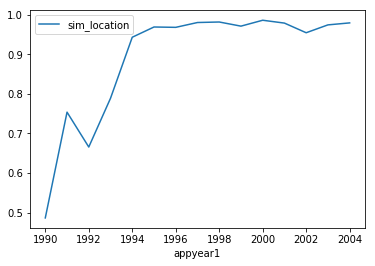

In [13]:
%matplotlib inline
# Plot
sim1.plot.line()

### 2.2 HHI

In [14]:
hhi = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(yr_min,yr_max+1)))

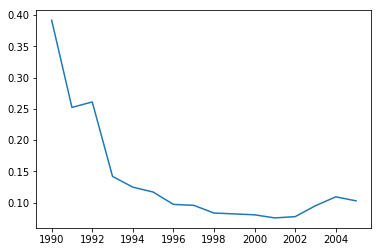

In [15]:
%matplotlib inline
# Plot
hhi.plot.line()